## Considerations for weather observations
### NSRDB low elevation issues
As described in https://github.com/AssessingSolar/unofficial-psm3-userguide/issues/19, the NSRDB has a known issue with cloud detection at low solar elevations (high solar zenith). This has also been described by Yang [1] and Buster (https://doi.org/10.1016/j.solener.2022.01.004).

During overcast periods near sunrise and sunset, the NSRDB can miss clouds and show much higher irradiance and actual irradiance. This can cause issues with training models related to forecast uncertainty, as forecasts often capture these conditions reasonably well, but the NSRDB would make it look like there was a very large error. 

The solution used here is to use HRRR analysis (F00) for actual weather. 

_For reference, HRRR actuals have been studied for use in wind modeling [3] and comparisons of 1-hour ahead HRRR irradiance forecasts (F01) were made with the NSRDB in a 2017 paper [4] although this was with a much older version of the HRRR._

[1] Yang, Dahzi. Validation of the 5-min irradiance from the National Solar Radiation Database (NSRDB). JRSE 2021. https://doi.org/10.1063/5.0030992

[2] Grant Buster, Mike Bannister, Aron Habte, Dylan Hettinger, Galen Maclaurin, Michael Rossol, Manajit Sengupta, Yu Xie, Physics-guided machine learning for improved accuracy of the National Solar Radiation Database, Solar Energy, 2022. https://doi.org/10.1016/j.solener.2022.01.004https://doi.org/10.1016/j.solener.2022.01.004

[3] Millstein, D., Jeong, S., Ancell, A. et al. A database of hourly wind speed and modeled generation for US wind plants based on three meteorological models. Sci Data 10, 883 (2023). https://doi.org/10.1038/s41597-023-02804-w

[4] Eric P. James, Stanley G. Benjamin, Melinda Marquis,
A unified high-resolution wind and solar dataset from a rapidly updating numerical weather prediction model,
Renewable Energy, 2017. https://doi.org/10.1016/j.renene.2016.10.059

In [1]:
from herbie import FastHerbie
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dateutil.relativedelta import relativedelta
from dateutil.parser import parse
import pvlib

### Get NSRDB observations and HRRR forecasts for sample days
Get HRRR forecast and coarsen it. 

January 8 and 9, 2021, are two days that are known to have this issue with cloud detection in the NSRDB. Because we are working with day-ahead forecasts, we will get forecasts produced on January 7 and 8:

In [2]:
start = '2021-01-07 06:00'
end = '2021-01-08 06:00'

DATES = pd.date_range(start=start, end=end, freq='24h')
fxx = range(27,45)
variables_list = ['DSWRF:surface','TMP:2 m','[U|V]GRD:10 m'] 
FH = FastHerbie(DATES, model="HRRR", product="sfc", fxx=fxx)

ds_dict = {}
for i in range(0,len(variables_list)):
    ds_dict[i] = FH.xarray(variables_list[i],remove_grib=True)

ds = xr.merge(ds_dict.values(), compat='override')
del ds_dict
xmin, xmax = 1080, 1440
ymin, ymax = 220, 440
ds = ds.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))

ds = ds.assign(t2m_c=ds['t2m'] - 273.15)
ds = ds.assign(wspd=np.sqrt(ds['u10']**2 + ds['v10']**2))

window_size = 10
ds_coarse = ds.coarsen(x=window_size, y=window_size, boundary='trim').mean()
ds_coarse_max = ds.coarsen(x=window_size, y=window_size, boundary='trim').max()
ds_coarse_min = ds.coarsen(x=window_size, y=window_size, boundary='trim').min() 

valid_start = (parse(start) + relativedelta(hours = min(fxx))).isoformat()
valid_end = (parse(end) + relativedelta(hours = max(fxx))).isoformat()

Load plant data and get NSRDB data:

In [3]:
plants_df = pd.read_csv('pv_fleet_metadata_rev3.csv') # read in as a Pandas DataFrame
plants_df = plants_df[plants_df['ac_capacity']>=10].copy().reset_index()
num_plants = len(plants_df.index) # number of plants

year = 2021
interval = 30

nsrdb_data_dict = {}
nsrdb_metadata_dict = {}

data_filename = 'nsrdb_data_dictionary_pickle_' + str(year) + '_60min_top_of_hour_from_30min.pickle'
metadata_filename = 'nsrdb_metadata_dictionary_pickle_' + str(year) + '_60min_top_of_hour_from_30min.pickle'

try: 
    # try to load dictionaries from existing pickle files
    pickle_in = open('example_data/'+data_filename, 'rb')
    nsrdb_data_dict = pickle.load(pickle_in)
    pickle_in = open('example_data/'+metadata_filename, 'rb')
    nsrdb_metadata_dict = pickle.load(pickle_in)
    print('loaded dictionaries from existing pickle files')
except: # if the pickle files don't exist, get NSRDB data, store in dictionaries, save as pickle files
    print('downloading new data from the NSRDB')
    
    ## API key credentials are stored in a separate text file
    with open('nrel_api_key_details.txt') as f: # full path and filename of text file with email on first line and api key on second line
        email = f.readline().rstrip()  # rstrip removes trailing line breaks and spaces
        nrel_api_key = f.readline().rstrip()
    for x in range(0,num_plants):
        lat = plants_df.iloc[x]['latitude'] 
        lon = plants_df.iloc[x]['longitude']
        nsrdb_data_dict[x], nsrdb_metadata_dict[x] = pvlib.iotools.get_psm3(latitude=lat,
                                                longitude=lon,
                                                api_key=nrel_api_key,
                                                email=email,
                                                names=year,
                                                interval=interval,
                                                leap_day=True,
                                                map_variables=True
                                                )

        # convert to UTC
        nsrdb_data_dict[x].index = nsrdb_data_dict[x].index.tz_convert('UTC')

        # only keep values that are centered on top of the hour 
        # to match HRRR hourly. See 
        # https://assessingsolar.github.io/unofficial-psm3-userguide/pages/data-aggregation.html
        nsrdb_data_dict[x] = nsrdb_data_dict[x].loc[nsrdb_data_dict[x]['Minute'] == 0]

        # adjust metadata to match
        nsrdb_metadata_dict[x]['Time Zone'] = 0

        # save dictionaries as pickle files
        pickle_out = open('example_data/'+data_filename, 'wb')
        pickle.dump(nsrdb_data_dict, pickle_out)
        pickle_out.close()

        pickle_out = open('example_data/'+metadata_filename, 'wb')
        pickle.dump(nsrdb_metadata_dict, pickle_out)
        pickle_out.close()
    print('done')

loaded dictionaries from existing pickle files


Define power model and HRRR data formatting functions:

In [4]:
def pvlib_power_model(resource_data, plant_data, calc_clear_sky = False):
    transposition_model = 'perez'
    eta_inv_nom = 0.98

    # solar position
    lat = plant_data['latitude'] 
    lon = plant_data['longitude']
    times = resource_data.index 
    loc= pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # dni and airmass
    dni_extra = pvlib.irradiance.get_extra_radiation(resource_data.index)
    airmass = pvlib.atmosphere.get_relative_airmass(
        solar_position.apparent_zenith,
        model='gueymard2003'
    )

    if calc_clear_sky == True:
        # simlified solis with aod700=0.05 and precipitable_water=0.5 appears to give 
        # good results; goal is to set an upper-bound, not necessarily to be as accurate 
        # as possible
        clear_sky = loc.get_clearsky(times,
                                     model='simplified_solis',
                                     dni_extra=dni_extra,
                                     aod700 = 0.05,
                                     precipitable_water = 0.5)
    
    # surface tilt and azimuth
    if plant_data['tracking_type'] == 'single_axis':  
        # tracker orientation angles
        singleaxis_kwargs = dict(apparent_zenith=solar_position.apparent_zenith,
                                 apparent_azimuth=solar_position.azimuth,
                                 axis_tilt=plant_data['axis_tilt'],
                                 axis_azimuth=plant_data['axis_azimuth'],
                                 backtrack=plant_data['backtrack'],
                                 gcr=plant_data['ground_coverage_ratio'],
                                 )
        orientation = pvlib.tracking.singleaxis(max_angle=plant_data['max_rotation_angle'],
                                                **singleaxis_kwargs)
        surface_tilt = orientation.surface_tilt.fillna(0)
        surface_azimuth = orientation.surface_azimuth.fillna(0)
    elif plant_data['tracking_type'] == 'fixed':
        surface_tilt = float(plant_data['fixed_tilt'])
        surface_azimuth = float(plant_data['fixed_azimuth'])

    # Transposed components of POA
    total_irradiance = pvlib.irradiance.get_total_irradiance(
        surface_tilt, 
        surface_azimuth,
        solar_position.apparent_zenith, 
        solar_position.azimuth, 
        resource_data.dni, 
        resource_data.ghi, 
        resource_data.dhi, 
        airmass=airmass,
        albedo=resource_data.albedo, 
        dni_extra=dni_extra, 
        model=transposition_model
    )

    # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
    t_cell = pvlib.temperature.faiman(total_irradiance.poa_global,
                                      resource_data.temp_air,
                                      resource_data.wind_speed,
    )

    # PVWatts dc power
    pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance.poa_global,
                                    t_cell,
                                    plant_data['dc_capacity'],
                                    plant_data['temperature_coefficient']/100)
    pdc0 = plant_data['ac_capacity']/eta_inv_nom # inverter dc input is ac nameplate divided by nominal inverter efficiency
    pdc_inv = pdc*(1-plant_data['dc_loss_factor']) # dc power into the inverter is modeled pdc after losses

    # PVWatts ac power
    power_ac = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    if calc_clear_sky==True:
        # Transposed components of POA
        total_irradiance = pvlib.irradiance.get_total_irradiance(
            surface_tilt, 
            surface_azimuth,
            solar_position.apparent_zenith, 
            solar_position.azimuth, 
            clear_sky.dni, 
            clear_sky.ghi, 
            clear_sky.dhi, 
            airmass=airmass,
            albedo=resource_data.albedo, 
            dni_extra=dni_extra, 
            model=transposition_model
        )

        # steady state cell temperature - faiman is much faster than fuentes, simpler than sapm
        t_cell = pvlib.temperature.faiman(total_irradiance.poa_global,
                                        resource_data.temp_air,
                                        resource_data.wind_speed,
        )

        # PVWatts dc power
        pdc = pvlib.pvsystem.pvwatts_dc(total_irradiance.poa_global,
                                        t_cell,
                                        plant_data['dc_capacity'],
                                        plant_data['temperature_coefficient']/100)
        pdc0 = plant_data['ac_capacity']/eta_inv_nom # inverter dc input is ac nameplate divided by nominal inverter efficiency
        pdc_inv = pdc*(1-plant_data['dc_loss_factor']) # dc power into the inverter is modeled pdc after losses

        # PVWatts ac power
        power_ac_clear_sky = pvlib.inverter.pvwatts(pdc_inv, pdc0, eta_inv_nom)

    if calc_clear_sky == True:
        return power_ac, power_ac_clear_sky
    else:
        return power_ac

def prep_hrrr_data(plant_data, forecast_df, decomposition_model = 'ers', albedo = 0.2):
    # Resource data
    plant_code = plant_data['plant_code']
    # arrange weather data for plant
    resource_data = forecast_df.loc[forecast_df['plant_code'] == plant_code,
                                ['valid_time_utc','dswrf', 't2m_c','wspd']].copy()
    resource_data = resource_data.set_index('valid_time_utc')
    resource_data.index = resource_data.index.tz_localize(tz='UTC')
    resource_data.rename(columns={'dswrf':'ghi', 't2m_c':'temp_air', 'wspd':'wind_speed'},
                    inplace=True)
    
    # solar position
    lat = plant_data['latitude'] 
    lon = plant_data['longitude']
    times = resource_data.index 
    loc= pvlib.location.Location(latitude=lat, longitude=lon, tz=times.tz)
    solar_position = loc.get_solarposition(times)

    # decomposition
    if decomposition_model=='erbs':
        out_erbs = pvlib.irradiance.erbs(
            resource_data.ghi,
            solar_position.zenith,
            resource_data.index,
        )
        resource_data['dni'] = out_erbs.dni
        resource_data['dhi'] = out_erbs.dhi
    elif decomposition_model=='dirint':
        dni_dirint = pvlib.irradiance.dirint(
            resource_data.ghi,
            solar_position.zenith,
            resource_data.index,
        )
        df_dirint = pvlib.irradiance.complete_irradiance(
            solar_zenith=solar_position.apparent_zenith,
            ghi=resource_data.ghi,
            dni=dni_dirint, dhi=None,
        )
        resource_data['dni'] = dni_dirint
        resource_data['dhi'] = df_dirint.dhi
    
    resource_data['albedo'] = albedo

    return resource_data

Calculate power with NSRDB data:

In [5]:
power_ac_nsrdb = {}
power_ac_cs = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()
    resource_data = nsrdb_data_dict[x]
    power_ac_nsrdb[x], power_ac_cs[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=True,
    )
    
power_ac_nsrdb_all = pd.concat(power_ac_nsrdb, axis=1, sort=False).sum(axis=1)
power_ac_nsrdb_all = power_ac_nsrdb_all.to_frame(name='power_ac')
power_ac_nsrdb_all.index.names = ['time_center_labeled']

power_ac_cs_all = pd.concat(power_ac_cs, axis=1, sort=False).sum(axis=1)
power_ac_cs_all = power_ac_cs_all.to_frame(name='power_ac')
power_ac_cs_all.index.names = ['time_center_labeled']

Process HRRR data and model power:

In [6]:
# original HRRR
df_hrrr_plants = ds.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants = df_hrrr_plants.merge(plants_df[['plant_code','ac_capacity']],
                                       left_on='point', right_on='plant_code')
df_hrrr_plants.drop(columns={'plant_code', 'surface', 'heightAboveGround', 
                             'metpy_crs', 'gribfile_projection'}, inplace=True)
df_hrrr_plants.rename(columns={'time':'time_utc','valid_time':'valid_time_utc',
                               'point':'plant_code'},
                      inplace=True)

# coarse mean
df_hrrr_plants_coarse = ds_coarse.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse = df_hrrr_plants_coarse.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )

# max
df_hrrr_plants_coarse_max = ds_coarse_max.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse_max = df_hrrr_plants_coarse_max.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse_max.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse_max.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )

# min
df_hrrr_plants_coarse_min = ds_coarse_min.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_plants_coarse_min = df_hrrr_plants_coarse_min.merge(
    plants_df[['plant_code','ac_capacity']],
    left_on='point', right_on='plant_code'
    )
df_hrrr_plants_coarse_min.drop(
    columns={'plant_code', 'surface', 'heightAboveGround', 
             'metpy_crs', 'gribfile_projection'},
             inplace=True
             )
df_hrrr_plants_coarse_min.rename(
    columns={'time':'time_utc','valid_time':'valid_time_utc',
             'point':'plant_code'},
             inplace=True
             )
decomposition_model = 'erbs' # dirint or erbs
albedo = 0.2 # generic albedo value to use for the forecasts - something better could be added later

power_ac_hrrr = {}
p_ac_hrrr_coarse = {}
p_ac_hrrr_coarse_max = {}
p_ac_hrrr_coarse_min = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()

    # original hrrr
    resource_data = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    power_ac_hrrr[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=False,
    )

    # coarse mean
    resource_data_coarse = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse[x] = pvlib_power_model(
        resource_data_coarse,
        plant_data,
        calc_clear_sky=False,
    )

    # coarse max
    resource_data_coarse_max = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse_max,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse_max[x] = pvlib_power_model(
        resource_data_coarse_max,
        plant_data,
        calc_clear_sky=False,
    )

    # coarse min
    resource_data_coarse_min = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_plants_coarse_min,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_coarse_min[x] = pvlib_power_model(
        resource_data_coarse_min,
        plant_data,
        calc_clear_sky=False,
    )

power_ac_hrrr_all = pd.concat(power_ac_hrrr, axis=1, sort=False).sum(axis=1)
power_ac_hrrr_all = power_ac_hrrr_all.to_frame(name='power_ac')
power_ac_hrrr_all.index.names = ['time_center_labeled']

p_ac_hrrr_coarse_all = pd.concat(p_ac_hrrr_coarse, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_all = p_ac_hrrr_coarse_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_all.index.names = ['time_center_labeled']

p_ac_hrrr_coarse_max_all = pd.concat(p_ac_hrrr_coarse_max, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_max_all = p_ac_hrrr_coarse_max_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_max_all.index.names = ['time_center_labeled']

p_ac_hrrr_coarse_min_all = pd.concat(p_ac_hrrr_coarse_min, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_coarse_min_all = p_ac_hrrr_coarse_min_all.to_frame(name='power_ac')
p_ac_hrrr_coarse_min_all.index.names = ['time_center_labeled']

### Compare results
Now, let's plot everything:

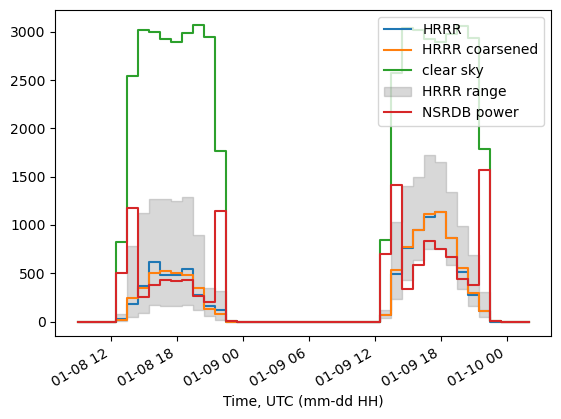

In [7]:
mask = (power_ac_nsrdb_all.index >= valid_start) & (power_ac_nsrdb_all.index <= valid_end)

plt.plot(power_ac_hrrr_all.index, power_ac_hrrr_all.power_ac, drawstyle='steps-mid',
         label='HRRR')
plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(power_ac_nsrdb_all.loc[mask].index, 
         power_ac_nsrdb_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='NSRDB power')
plt.legend(loc='upper right')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

Notice in the morning and evening on both days there are "spikes" in NSRDB power, well above what what was forecasted. Let's look more closely at the 9th:

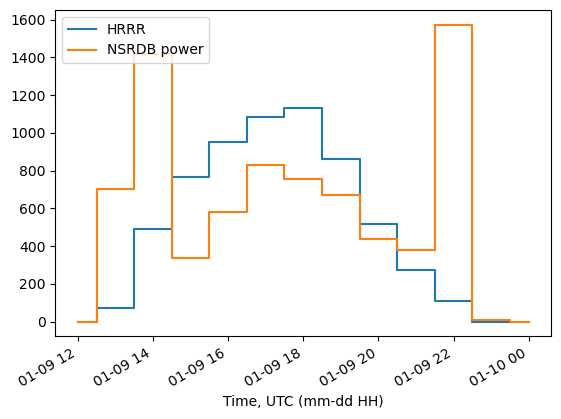

In [8]:
mask = (power_ac_nsrdb_all.index >= '2021-01-09 12:00') & (power_ac_nsrdb_all.index <= '2021-01-10')
mask2 = (power_ac_hrrr_all.index >= '2021-01-09 12:00') & (power_ac_hrrr_all.index <= '2021-01-10')

plt.plot(power_ac_hrrr_all.loc[mask2].index, power_ac_hrrr_all.loc[mask2].power_ac, drawstyle='steps-mid',
         label='HRRR')

plt.plot(power_ac_nsrdb_all.loc[mask].index, 
         power_ac_nsrdb_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='NSRDB power')
plt.legend(loc='upper left')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

### Compare with satellite images of clouds
The evening is particularly notable at hour 22:00. To confirm that there were in fact heavy clouds in that hour, we can use GOES-2-go [1] to view satellite images.

[1] Blaylock, B. K. (2023). GOES-2-go: Download and display GOES-East and GOES-West data (Version 2022.07.15) [Computer software]. https://github.com/blaylockbk/goes2go

c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\goes2go\data.py:519: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\goes2go\NEW.py:188: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  within=pd.to_timedelta(config["nearesttime"].get("within", "1H")),
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\goes2go\data.py:136: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  DATES = pd.date_range(f"{start:%Y-%m-%d %H:00}", f"{end:%Y-%m-%d %H:00}", freq="1H")


 👮🏻‍♂️ File already exists. Do not overwrite: C:\Users\willh\data\noaa-goes16\ABI-L2-MCMIPC\2021\008\22\OR_ABI-L2-MCMIPC-M6_G16_s20210082201165_e20210082203544_c20210082204091.nc
📦 Finished downloading [1] files to [C:\Users\willh\data\noaa-goes16\ABI-L2-MCMIPC].
📚 Finished reading [1] files into xarray.Dataset.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)
c:\Users\willh\miniforge3\envs\pvlib_herbie_env3\lib\site-packages\matplotlib\cm.py:494: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


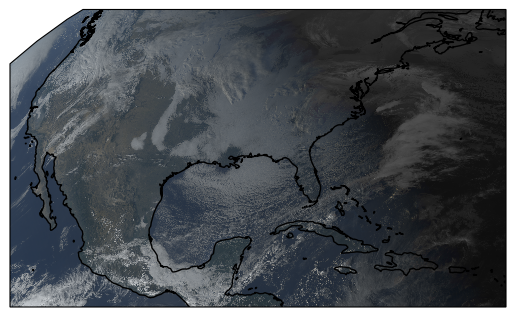

In [9]:
from goes2go import GOES
import matplotlib.pyplot as plt
from toolbox import EasyMap, pc, ccrs

G = GOES().nearesttime('2021-01-08 22:00')
ax = plt.subplot(projection=G.rgb.crs)
ax.imshow(G.rgb.TrueColor(), **G.rgb.imshow_kwargs)
ax.coastlines()

And here we can see that nearly the entire Southeast US is covered in solid clouds. 

### Using HRRR analysis for observations
As a solution, we will use HRRR analysis (forecast horizon of zero hours, or F00) for actual weather in this project. Alternatives could include:
- Use the NSRDB, but exclude intervals with solar elevation less than 10 degrees (zenith greater than 80 degrees)
- Use the NSRDB, but manually filter out erroneous intervals
- Use another source of satellite data
- Use ground-measured data

Let's pull F00 HRRR values:

In [10]:
start = '2021-01-08 12:00'
end = '2021-01-10 00:00'

DATES = pd.date_range(start=start, end=end, freq='1h')
fxx = range(0,1)
variables_list = ['DSWRF:surface','TMP:2 m','[U|V]GRD:10 m'] 
FH = FastHerbie(DATES, model="HRRR", product="sfc", fxx=fxx)

ds_dict = {}
for i in range(0,len(variables_list)):
    ds_dict[i] = FH.xarray(variables_list[i], remove_grib=True, overwrite=True)

ds_actuals = xr.merge(ds_dict.values(), compat='override')
del ds_dict
xmin, xmax = 1080, 1440
ymin, ymax = 220, 440
ds_actuals = ds_actuals.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))

ds_actuals = ds_actuals.assign(t2m_c=ds_actuals['t2m'] - 273.15)
ds_actuals = ds_actuals.assign(wspd=np.sqrt(ds_actuals['u10']**2 + ds_actuals['v10']**2))

Process and calculate power:

In [11]:
# original HRRR
df_hrrr_actuals = ds_actuals.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_actuals = df_hrrr_actuals.merge(plants_df[['plant_code','ac_capacity']],
                                       left_on='point', right_on='plant_code')
df_hrrr_actuals.drop(columns={'plant_code', 'surface', 'heightAboveGround', 
                             'metpy_crs', 'gribfile_projection'}, inplace=True)
df_hrrr_actuals.rename(columns={'time':'time_utc','valid_time':'valid_time_utc',
                               'point':'plant_code'},
                      inplace=True)

decomposition_model = 'erbs' # dirint or erbs
albedo = 0.2 # generic albedo value to use for the forecasts - something better could be added later

power_ac_hrrr_actuals = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()

    resource_data = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_actuals,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    power_ac_hrrr_actuals[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=False,
    )
power_ac_hrrr_actuals_all = pd.concat(power_ac_hrrr_actuals, axis=1, sort=False).sum(axis=1)
power_ac_hrrr_actuals_all = power_ac_hrrr_actuals_all.to_frame(name='power_ac')
power_ac_hrrr_actuals_all.index.names = ['time_center_labeled']

And plot the new results:

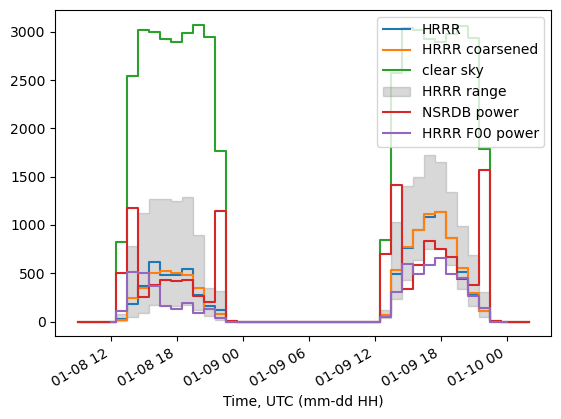

In [12]:
mask = (power_ac_nsrdb_all.index >= valid_start) & (power_ac_nsrdb_all.index <= valid_end)

plt.plot(power_ac_hrrr_all.index, power_ac_hrrr_all.power_ac, drawstyle='steps-mid',
         label='HRRR')
plt.plot(p_ac_hrrr_coarse_all.index, p_ac_hrrr_coarse_all.power_ac, drawstyle='steps-mid',
         label='HRRR coarsened')
plt.plot(power_ac_cs_all.loc[mask].index, power_ac_cs_all.loc[mask].power_ac,
         drawstyle='steps-mid', label='clear sky')
plt.fill_between(p_ac_hrrr_coarse_min_all.index,
                 p_ac_hrrr_coarse_min_all.power_ac,
                 p_ac_hrrr_coarse_max_all.power_ac,
                 step='mid', color="gray", alpha=0.3, label='HRRR range')
plt.plot(power_ac_nsrdb_all.loc[mask].index, 
         power_ac_nsrdb_all.loc[mask].power_ac,
         drawstyle='steps-mid',
         label='NSRDB power')
plt.plot(power_ac_hrrr_actuals_all.index, 
         power_ac_hrrr_actuals_all.power_ac,
         drawstyle='steps-mid',
         label='HRRR F00 power')
plt.legend(loc='upper right')
plt.gcf().autofmt_xdate()
plt.xlabel('Time, UTC (mm-dd HH)')
plt.show()

You can see that the HRRR-based actuals (F00) do not have the same issue with irradiance spikes near sunrise/sunset, so we will use the HRRR for actuals moving forward. 

Let's repeat that process for the date range we have been exploring, April 9-12, 2021, and save the output for use later.

In [13]:
start = '2021-04-09 06:00'
end = '2021-04-13 06:00'

DATES = pd.date_range(start=start, end=end, freq='1h')
fxx = range(0,1)
variables_list = ['DSWRF:surface','TMP:2 m','[U|V]GRD:10 m'] 
FH = FastHerbie(DATES, model="HRRR", product="sfc", fxx=fxx)

ds_dict = {}
for i in range(0,len(variables_list)):
    ds_dict[i] = FH.xarray(variables_list[i], remove_grib=True, overwrite=True)

ds_actuals = xr.merge(ds_dict.values(), compat='override')
del ds_dict
xmin, xmax = 1080, 1440
ymin, ymax = 220, 440
ds_actuals = ds_actuals.sel(x=slice(xmin, xmax), y=slice(ymin, ymax))

ds_actuals = ds_actuals.assign(t2m_c=ds_actuals['t2m'] - 273.15)
ds_actuals = ds_actuals.assign(wspd=np.sqrt(ds_actuals['u10']**2 + ds_actuals['v10']**2))

# original HRRR
df_hrrr_actuals = ds_actuals.herbie.nearest_points(points=plants_df,
                                           names=plants_df['plant_code']) \
                                            .to_dataframe().reset_index()
df_hrrr_actuals = df_hrrr_actuals.merge(plants_df[['plant_code','ac_capacity']],
                                       left_on='point', right_on='plant_code')
df_hrrr_actuals.drop(columns={'plant_code', 'surface', 'heightAboveGround', 
                             'metpy_crs', 'gribfile_projection'}, inplace=True)
df_hrrr_actuals.rename(columns={'time':'time_utc','valid_time':'valid_time_utc',
                               'point':'plant_code'},
                      inplace=True)

decomposition_model = 'erbs' # dirint or erbs
albedo = 0.2 # generic albedo value to use for the forecasts - something better could be added later

p_ac_hrrr_actuals = {}

for x in range(0,num_plants):
    plant_data = plants_df.iloc[x].dropna().to_dict()

    resource_data = prep_hrrr_data(
        plant_data,
        forecast_df=df_hrrr_actuals,
        decomposition_model=decomposition_model,
        albedo=albedo,
    )
    p_ac_hrrr_actuals[x] = pvlib_power_model(
        resource_data,
        plant_data,
        calc_clear_sky=False,
    )
p_ac_hrrr_actuals_all = pd.concat(p_ac_hrrr_actuals, axis=1, sort=False).sum(axis=1)
p_ac_hrrr_actuals_all = p_ac_hrrr_actuals_all.to_frame(name='power_ac')
p_ac_hrrr_actuals_all.index.names = ['time_center_labeled']

And save the resulting DataFrame in a pickle file for use later:

In [14]:
p_ac_hrrr_actuals_all.to_pickle('example_data/p_ac_hrrr_actuals_all.pkl')

The next notebook, [04_spatial_variation_in_irradiance.ipynb](04_spatial_variation_in_irradiance.ipynb) will look more at the "HRRR Range" (difference between coarsened max and min), which will be used later as a feature in a probabilistic forecast.